# Set-Up 
Run this first section every time, it has important path dependencies. Note that one should change the path variables. In general, the following structure for the data is expected:

Data <br>
|  Webshop A  <br>
|    ├─── ANNOS <br>
|    |      ├─── MALE <br>
|    |      |    ├─── CAT A <br>
|    |      |    |    ├─── ID_1 <br>
|    |      |    |    ├─── ID_2 <br>
|    |      |    |    ├─── ID_3 <br>
|    |      |    ├─── CAT B <br>
|    |      |    ├─── CAT C <br>
|    |      ├─── Female <br>
|    |      |    ├─── CAT D <br>
|    |      |    |    ├─── ID_1 <br>
|    |      |    |    ├─── ID_2 <br>
|    |      |    |    ├─── ID_3 <br>
|    |      |    ├─── CAT E <br>
|    ├─── IMG <br>
├─── Webshop B <br>
|    ├─── ANNOS <br>
├─── Webshop C <br>

In [1]:
# Import
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import random
import json
import string
import pickle
from sklearn import preprocessing, metrics
import os
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model

In [4]:
def create_cnn(maxwords, nr_classes, dimensions, word_index, embedding_matrix):
    # Add input layer
    input_layer = layers.Input((maxwords, ))
    
    # Add the word embedding layer
    embedding_layer = layers.Embedding(len(word_index) + 1, dimensions, weights = [embedding_matrix], 
                                       trainable = False)(input_layer)
    embedding_layer = layers.SpatialDropout1D(0.25)(embedding_layer)
    
    # Add convolutional layer
    conv_layer = layers.Convolution1D(maxwords, 3, activation = "relu")(embedding_layer)
    
    # Add pooling layer
    pooling_layer = layers.GlobalMaxPool1D()(conv_layer)
    
    
    # Add output layers
    output_layer1 = layers.Dense(50, activation="relu")(pooling_layer)
    output_layer1 = layers.Dropout(0.25)(output_layer1)
    output_layer2 = layers.Dense(nr_classes, activation="sigmoid")(output_layer1)
    
    model = models.Model(inputs = input_layer, outputs = output_layer2)
    model.compile(optimizer = optimizers.Adam(), loss = 'categorical_crossentropy',metrics = ['categorical_accuracy','accuracy'])
    
    return model

In [5]:
base_path = r'E:\\Jelmer\\Uni\\Thesis\\Data'

In [6]:
# Get list of folders, exclude some which do not have the standard structure
shops = []
for folder in os.listdir(base_path):
    if (os.path.isdir(os.path.join(base_path, folder))) & (folder not in ['1. NEW_BRAND','DeepFashion','Zara','ADIDAS',"FARFETCH", "Preprocessed"]):
        shops.append(os.path.join(base_path, folder))

# Training a classification model

In [5]:
# Function to randomly select a nr_items of paths to articles per web shop. It takes from the different categories. 
def get_stratified_sample_paths(path, nr_items_train = 1000, nr_items_test = 250):
    """Returns the paths to a specified number of items for a particular webshop based on a stratified sample across item categories.
    path: str - path name to annos folder of a webshop.
    nr_items: the number of items in total to return."""
    item_paths = []
    items_per_cat = {}
    to_select_per_cat = {}
    test_paths = []
    train_paths = []
    
    annos_path = os.path.join(path, "ANNOS")
    clothing_categories = os.listdir(annos_path)
    
    # Check whether men / women categories exist
    if "MEN" in clothing_categories:
        clothing_categories = []
        for gender in ["MEN", "WOMEN"]:
            new_path = os.path.join(annos_path, gender)
            
            for cat in os.listdir(new_path):
                last_part_of_path = os.path.join(gender, cat)
                clothing_categories.append(last_part_of_path)
    
    for cat in clothing_categories:
        cat_path = os.path.join(annos_path, cat)
        items_per_cat[cat] = len(os.listdir(cat_path))
        
    total_items = sum(items_per_cat.values())
#     print("There are a total of {} items spread over {} categories for this webshop".format(total_items,len(clothing_categories)))
    
    # Check whether there are more items available then needed; if not, return all items.
    if total_items <= nr_items_train + nr_items_test:
        for cat in clothing_categories:
#             print(cat, path)
            cat_path = os.path.join(annos_path, cat)
            for item in os.listdir(cat_path):
                if item.endswith(".txt"):
                    item_paths.append(os.path.join(cat_path, item))
                    
        test_paths = random.sample(item_paths, nr_items_test)
        train_paths = set(item_paths) - set(test_paths)
        return train_paths, test_paths
    
    
    # If there are more items available than needed take a selection
    for cat in clothing_categories:
        items_to_select_train = items_per_cat[cat] / total_items * nr_items_train
        items_to_select_test = items_per_cat[cat] / total_items * nr_items_test
        cat_path = os.path.join(annos_path, cat)
        all_items = os.listdir(cat_path)
        
        test_paths_cat = random.sample(all_items,int(items_to_select_test))
        remaining_paths_cat = set(all_items) - set(test_paths_cat)
        train_paths_cat = random.sample(remaining_paths_cat, int(items_to_select_train))
        test_paths += [os.path.join(cat_path, path) for path in test_paths_cat]
        train_paths += [os.path.join(cat_path, path) for path in train_paths_cat]
    return train_paths, test_paths

In [6]:
# Get paths
random.seed(0)
train_paths_all, test_paths_all = [], []
for shop_path in tqdm(shops):
#     print(shop_path)
    train_paths, test_paths = get_stratified_sample_paths(shop_path, 1000, 250)
    train_paths_all += train_paths
    test_paths_all += test_paths
# Ensure test_paths do not contain train_paths as well


In [7]:
train_paths = [path for path in train_paths_all if path not in test_paths_all]

In [8]:
len(test_paths_all), len(train_paths_all), len(train_paths)

(2612, 9949, 9949)

In [9]:
shop_mapping = {}
it = 0
for shop in shops:
    shop_mapping[shop] = it
    it += 1

In [10]:
# Function which loads a description and cleans it
def get_description(item_path):
    with open(item_path, 'r', encoding = "utf8") as f:
        item_dict = json.load(f)
    try:
        description = item_dict['description']
        if (description == "") | (description is None):
            return "","",""
    except KeyError:
        return "","",""
    # Clean description
    # remove punctuation
    description = description.translate(str.maketrans('', '', string.punctuation))
    description = description.lower()
    description = description.replace("<p>","")
    description = description.replace("</p>","")
    
    tokenized_description = description.split()
    
    tokenized_description = [word for word in tokenized_description if word.isalpha()]
    label_shop = shop_mapping[item_path.split("\\ANNOS")[0]]
    label_cloth_cat = item_path.split("\\")[-2]
    
    return ' '.join(tokenized_description), label_shop, label_cloth_cat

In [11]:
# function to load all descriptions and labels from a set of item_paths
def load_descriptions(item_paths):
    nr_items = len(item_paths)
    print("Loading {} items".format(nr_items))
    description_dict = {}
    label_dict = {}
    iterator = 0
    for item in tqdm(item_paths):
        iterator += 1
        try:
            desc, shop, _ = get_description(item)
            item_ID = item.split("\\")[-1]
            if desc == "":
                continue
            description_dict[item_ID] = desc
            label_dict[item_ID] = shop
        except UnicodeDecodeError:
            continue
    return description_dict, label_dict

In [12]:
%%time
# Load everything
description_dict_train, label_dict_train = load_descriptions(train_paths)
train_x = description_dict_train.values()
train_y = label_dict_train.values()

Loading 9949 items



Wall time: 1min 24s


In [13]:
%%time
description_dict_test, label_dict_test = load_descriptions(test_paths_all)
test_x = description_dict_test.values()
test_labels_y = list(label_dict_test.values())

Loading 2612 items



Wall time: 2.69 s


In [14]:
test_y = to_categorical(test_labels_y)

In [15]:
# Shuffle the train data to improve learning
train_data = list(zip(train_x, train_y))
random.shuffle(train_data)

train_x, train_y = zip(*train_data)

In [16]:
train_y = to_categorical(train_y)


In [17]:
# test max length of a description
words_p_desc = [len(item.split()) for item in train_x]
maxwords = max(words_p_desc)
# Max length is 97

In [18]:
%%time
# Load GloVe vectors:
glove_dir = r'E:\Jelmer\Uni\Thesis\Data\glove.6b.200d.txt'
embeddings_index = {}

f = open(glove_dir, encoding = 'UTF-8')

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype = 'float32')
    embeddings_index[word] = coefs
    
f.close()

Wall time: 2min 10s


In [19]:
with open("embeddings_index_source_classification.p", "wb") as f:
    pickle.dump(embeddings_index, f)

In [20]:
len(train_x)

9031

## Tokenizer

In [21]:
# create a tokenizer 
token = text.Tokenizer()
token.fit_on_texts(train_x)
word_index = token.word_index

with open("tokenizer.p", "wb") as f:
    pickle.dump(token, f)

# Convert text to sequence of tokens and pad them to ensure equal length vectors (80)
train_seq_x = sequence.pad_sequences(token.texts_to_sequences(train_x), maxlen = 70)
val_seq_x = sequence.pad_sequences(token.texts_to_sequences(test_x), maxlen = 70)

In [22]:
val_seq_x = sequence.pad_sequences(token.texts_to_sequences(test_x), maxlen = 70)

In [23]:
dimensions = 200
embedding_matrix = np.zeros((len(word_index) + 1, dimensions))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [24]:
with open("embedding_matrix_source_classification.p", "wb") as f:
    pickle.dump(embedding_matrix, f)
train_seq_x.shape

(9031, 70)

# CNN training

In [26]:
words_p_desc = 70
nr_classes = len(shops)
dimensions = 200
model_cnn = create_cnn(words_p_desc, nr_classes, dimensions, word_index, embedding_matrix)

In [27]:
model_cnn.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 70)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 70, 200)           1846600   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 70, 200)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 68, 70)            42070     
_________________________________________________________________
global_max_pooling1d (Global (None, 70)                0         
_________________________________________________________________
dense (Dense)                (None, 50)                3550      
_________________________________________________________________
dropout (Dropout)            (None, 50)                0     

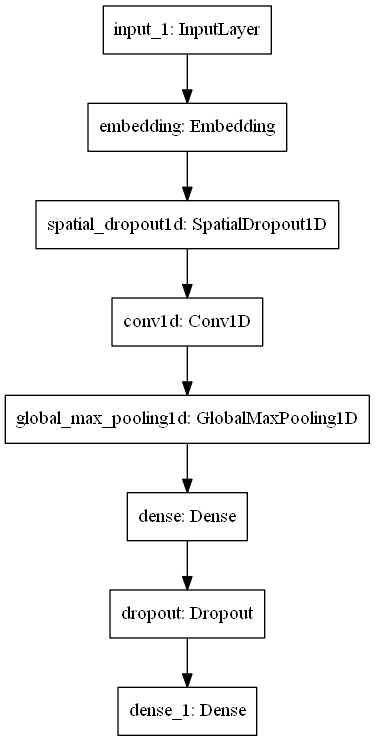

In [67]:
plot_model(model_cnn, "Model_image.png")

In [28]:
train_seq_x[1000]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    8,
         22, 1154,  950, 3424,  126,   76, 4809,    3,  488,    7,  248,
       3425, 3960,   30,  836, 1265, 3961, 3962,    5, 3426,    7,    1,
        644,  229,    7, 3056, 2761,    6,  347, 3963,  184,   37,    5,
         22, 1369,   72, 6264])

In [29]:
cnn_history = model_cnn.fit(train_seq_x, train_y, batch_size = 32, epochs = 10, shuffle = True, validation_split = 0.1)

Train on 8127 samples, validate on 904 samples
Epoch 1/10
8127/8127 [==============================] - 27s 3ms/sample - loss: 1.6311 - categorical_accuracy: 0.4715 - accuracy: 0.4715 - val_loss: 0.7485 - val_categorical_accuracy: 0.7754 - val_accuracy: 0.7754
Epoch 2/10
8127/8127 [==============================] - 11s 1ms/sample - loss: 0.6931 - categorical_accuracy: 0.7816 - accuracy: 0.7816 - val_loss: 0.4542 - val_categorical_accuracy: 0.8440 - val_accuracy: 0.8440
Epoch 3/10
8127/8127 [==============================] - 10s 1ms/sample - loss: 0.4580 - categorical_accuracy: 0.8532 - accuracy: 0.8532 - val_loss: 0.3696 - val_categorical_accuracy: 0.8805 - val_accuracy: 0.8805
Epoch 4/10
8127/8127 [==============================] - 10s 1ms/sample - loss: 0.3508 - categorical_accuracy: 0.8902 - accuracy: 0.8902 - val_loss: 0.3128 - val_categorical_accuracy: 0.8949 - val_accuracy: 0.8949
Epoch 5/10
8127/8127 [==============================] - 10s 1ms/sample - loss: 0.2746 - categorical_a

In [30]:
predictions = model_cnn.predict(val_seq_x)

In [31]:
predictions = predictions.argmax(axis = -1)

In [32]:
predictions

array([ 0,  0,  0, ..., 10, 10, 10], dtype=int64)

In [33]:
metrics.accuracy_score(predictions, test_labels_y)

0.9270965023177412

In [34]:
metrics.confusion_matrix(predictions, test_labels_y)

array([[211,   1,   0,  10,   3,   2,  10,   0,   1,   2,   0],
       [  0, 211,   0,   1,   1,   0,   2,   0,   6,   2,   0],
       [  0,   0, 236,   0,   0,   0,   2,   0,   0,   0,   0],
       [  8,   5,   0, 102,   3,   1,   6,   1,  10,  10,  17],
       [  3,   0,   0,   3, 218,   0,   4,   0,   2,   0,   6],
       [  0,   0,   0,   0,   0, 221,   0,   0,   0,   0,   0],
       [  3,   0,   0,   2,   3,   1, 214,   0,   0,   2,  10],
       [  0,   0,   0,   1,   2,   0,   2, 249,   3,   0,   2],
       [  3,   5,   0,   4,   0,   0,   0,   0, 173,   2,   0],
       [  0,   1,   0,   3,   1,   0,   0,   0,   1, 150,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 215]],
      dtype=int64)

In [35]:
model_json = model_cnn.to_json()
with open("model_cnn.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model_cnn.save_weights("model_cnn.h5")
print("Saved model to disk")

Saved model to disk


# Test predictions by generation models
Results folder should have following structure: <br>
. <br>
Results <br>
----w1_results <br>
--------all_results <br>
----w2_results <br>
--------all_results <br>
----w3_results <br>
--------all_results <br>
----w4_results <br>
--------all_results <br>

In [2]:
base_path = r'E:\\Jelmer\\Uni\\Thesis\\Data'
# Get list of folders, exclude some which do not have the standard structure
shops = []
for folder in os.listdir(base_path):
    if (os.path.isdir(os.path.join(base_path, folder))) & (folder not in ['1. NEW_BRAND','DeepFashion','Zara','ADIDAS',"FARFETCH", "Preprocessed"]):
        shops.append(os.path.join(base_path, folder))

In [8]:
with open("embedding_matrix_source_classification.p", "rb") as f:
    embedding_matrix = pickle.load(f)
with open("tokenizer.p", "rb") as f:
    token = pickle.load(f)
word_index = token.word_index
words_p_desc = 70
nr_classes = len(shops)
dimensions = 200
model_cnn = create_cnn(words_p_desc, nr_classes, dimensions, word_index, embedding_matrix)
model_cnn.load_weights("model_cnn.h5")

In [9]:
# Test RL, MA, AE, UO preds and refs
res_path = r"C:\Users\s159655\Documents\JADS\Thesis\RESULTS\Results_Paper"
with open(os.path.join(res_path, "rl_results", "all_results", "results_dictRL_config_411.json"), 'r') as f:
    rl_res = json.load(f)
with open(os.path.join(res_path, "ma_results", "all_results", "results_dictMA_config_411.json"), 'r') as f:
    ma_res = json.load(f)
with open(os.path.join(res_path, "uo_results", "all_results", "results_dictUO_config_411.json"), 'r') as f:
    uo_res = json.load(f)
with open(os.path.join(res_path, "ae_results", "all_results", "results_dictAE_config_411.json"), 'r') as f:
    ae_res = json.load(f)

In [10]:
preds_rl, refs_rl = rl_res["PREDICTIONS"], rl_res["REFERENCES"]
preds_ma, refs_ma = ma_res["PREDICTIONS"], ma_res["REFERENCES"]
preds_ae, refs_ae = ae_res["PREDICTIONS"], ae_res["REFERENCES"]
preds_uo, refs_uo = uo_res["PREDICTIONS"], uo_res["REFERENCES"]

In [11]:
def compute_webshop_results(preds, refs, label):
    labels = [label for i in range(len(preds))]
    refs = [i[0] for i in refs]
    predsx = sequence.pad_sequences(token.texts_to_sequences(preds), maxlen = 70)
    refsx = sequence.pad_sequences(token.texts_to_sequences(refs), maxlen = 70)
    
    # Make predictions
    predictions_p = model_cnn.predict(predsx)
    predictions_p = predictions_p.argmax(axis = -1)
    
    predictions_r = model_cnn.predict(refsx)
    predictions_r = predictions_r.argmax(axis = -1)
    

    # Measures
    acc_p = metrics.accuracy_score(predictions_p, labels)
    acc_r = metrics.accuracy_score(predictions_r, labels)
    
    # Percentage ref is correct but prediction not
    w_style = 0
    for ix, p in enumerate(predictions_p):
        if p != label:
            if predictions_r[ix] == label:
                w_style += 1
    acc_pofr = w_style / len(labels)
    
    return acc_p, acc_r, acc_pofr

def compute_multiplewebshop_results(preds, refs, refs_list_webshops):
    shop_dict = {"AE": 0, "MA": 4, "RL": 8, "UO": 9}
    
    labels = []
    for ref in refs:
        if ref in refs_list_webshops["RL"]:
            labels.append(shop_dict["RL"])
        elif ref in refs_list_webshops["MA"]:
            labels.append(shop_dict["MA"])
        elif ref in refs_list_webshops["AE"]:
            labels.append(shop_dict["AE"])
        elif ref in refs_list_webshops["UO"]:
            labels.append(shop_dict["UO"])
        else:
            print("ref not found: ", ref)
    refs = [i[0] for i in refs]
    predsx = sequence.pad_sequences(token.texts_to_sequences(preds), maxlen = 70)
    refsx = sequence.pad_sequences(token.texts_to_sequences(refs), maxlen = 70)
    
    # Make predictions
    predictions_p = model_cnn.predict(predsx)
    predictions_p = predictions_p.argmax(axis = -1)
    
    predictions_r = model_cnn.predict(refsx)
    predictions_r = predictions_r.argmax(axis = -1)
    
    # Measures
    acc_p = metrics.accuracy_score(predictions_p, labels)
    acc_r = metrics.accuracy_score(predictions_r, labels)
    
    # Percentage ref is correct but prediction not
    w_style = 0
    for ix, p in enumerate(predictions_p):
        if p != labels[ix]:
            if predictions_r[ix] == labels[ix]:
                w_style += 1
    acc_pofr = w_style / len(labels)
    
    return acc_p, acc_r, acc_pofr

def compute_results_config(configs):
    shop_dict = {"AE": 0, "MA": 4, "RL": 8, "UO": 9}
    results = []
    for config in configs:
        print(f"Working on {config}")
        for webshop in ["AE", "MA", "RL", "UO"]:
            print(f"Doing {webshop}")
            # load data
            if type(config) == dict:
                c = config["AE"]
                try:
                    with open(os.path.join(res_path, f"{webshop.lower()}_results", "all_results", f"results_dict{webshop}_{config[webshop]}"), 'r') as f:
                        resdict = json.load(f)
                except FileNotFoundError:
                    with open(os.path.join(res_path, f"{webshop.lower()}_results", "all_results", f"results_dict_{webshop}_{config[webshop]}"), 'r') as f:
                        resdict = json.load(f)
            else:
                c = config
                with open(os.path.join(res_path, f"{webshop.lower()}_results", "all_results", f"results_dict{webshop}_{config}"), 'r') as f:
                    resdict = json.load(f)
            preds, refs = resdict["PREDICTIONS"], resdict["REFERENCES"]

            label = shop_dict[webshop]

            pred_acc, ref_acc, perc_refnotpred = compute_webshop_results(preds, refs, label)
            print("results:  ", pred_acc, ref_acc, perc_refnotpred)
            results.append((c, webshop, pred_acc, ref_acc, perc_refnotpred, len(preds)))
            
    return results

def compute_results_multishop(configs_multi, refs_list):
    """configs_multi: list with configuration names
    refs_dict: dictionary with webshop : [refs]"""
    
    results = []
    for config in configs_multi:
        with open(os.path.join(res_path, "COMBINED", f"results_dict_{config}"), 'r') as f:
                resdict = json.load(f)
        preds = resdict["PREDICTIONS"]
        refs = resdict["REFERENCES"]
        # Load 
        print(f"Working on {config}")
        # load data
        pred_acc, ref_acc, perc_refnotpred = compute_multiplewebshop_results(preds, refs, refs_list)
        print("results:  ", pred_acc, ref_acc, perc_refnotpred)
        results.append((config, pred_acc, ref_acc, perc_refnotpred))
            
    return results

In [54]:
style_results = compute_results_config(["config_411.json", "config_402.json", "config_403.json", "config_409.json"])

Working on config_411.json
Doing AE
results:   0.9674609274916731 0.9587496797335383 0.023059185242121444
Doing MA
results:   0.9636498516320475 0.9499258160237388 0.030044510385756677
Doing RL
results:   0.9365871036693979 0.9369433558959743 0.050944068400427506
Doing UO
results:   0.9196891191709845 0.9158031088082902 0.06363341968911918
Working on config_402.json
Doing AE
results:   0.9661798616448886 0.9587496797335383 0.02638995644376121
Doing MA
results:   0.9699554896142433 0.9499258160237388 0.024851632047477746
Doing RL
results:   0.940149625935162 0.9369433558959743 0.04809405058781618
Doing UO
results:   0.9512629533678757 0.9158031088082902 0.039345854922279794
Working on config_403.json
Doing AE
results:   0.9736100435562388 0.9587496797335383 0.021009479887266206
Doing MA
results:   0.9755192878338279 0.9499258160237388 0.020029673590504452
Doing RL
results:   0.9504809405058782 0.9369433558959743 0.04096900605628785
Doing UO
results:   0.9238989637305699 0.91580310880829

In [55]:
%%time
style_results_2 = compute_results_config([{"AE": "config_6.json", "UO": "config_6.json", "MA": "config_6.json", 
                                           "RL": "config_66.json"}, {"AE": "config_10.json", "UO": "config_10.json", "MA": "config_10.json", 
                                           "RL": "config_72.json"}])

Working on {'AE': 'config_6.json', 'UO': 'config_6.json', 'MA': 'config_6.json', 'RL': 'config_66.json'}
Doing AE
results:   0.9738662567255957 0.9587496797335383 0.01870356136305406
Doing MA
results:   0.9770029673590505 0.9499258160237388 0.018916913946587538
Doing RL
results:   0.9429996437477735 0.9369433558959743 0.04631278945493409
Doing UO
results:   0.9632448186528497 0.9158031088082902 0.028335492227979275
Working on {'AE': 'config_10.json', 'UO': 'config_10.json', 'MA': 'config_10.json', 'RL': 'config_72.json'}
Doing AE
results:   0.9866769151934409 0.9587496797335383 0.008967460927491674
Doing MA
results:   0.9888724035608308 0.9499258160237388 0.008160237388724036
Doing RL
results:   0.9832561453509084 0.9369433558959743 0.01460634128963306
Doing UO
results:   0.9386334196891192 0.9158031088082902 0.052461139896373056
Wall time: 1min 1s


In [56]:
style_results.extend(style_results_2)

In [ ]:
style_results = pd.DataFrame(style_results, columns = ["Configuration", "Accuracy Predictions", "Accuracy References", "Additional Wrong Styles", "Nr. References"])
style_results.head()

In [61]:
style_results.to_excel("Classification_style_acc_p_webshop.xlsx")

In [60]:
# Compute combined accuracy for these web shops
style_results["Nr. Wrong - Preds"] = (1 - style_results["Accuracy Predictions"])*style_results["Nr. References"]
style_results["Nr. Wrong - Refs"] = (1 - style_results["Accuracy References"])*style_results["Nr. References"]
combined_individual = pd.DataFrame(style_results.groupby("Configuration")[["Nr. References", "Nr. Wrong - Preds", 
                                                                           "Nr. Wrong - Refs"]].sum())
combined_individual["Accuracy Predictions"] = 1 - (combined_individual["Nr. Wrong - Preds"]/combined_individual["Nr. References"])
combined_individual["Accuracy References"] = 1 - (combined_individual["Nr. Wrong - Refs"]/combined_individual["Nr. References"])
combined_individual                                   

,Nr. References,Nr. Wrong - Preds,Nr. Wrong - Refs,Accuracy Predictions,Accuracy References
Configuration,,,,,
config_10.json,15582,508.0,993.0,0.967398,0.936273
config_402.json,15582,682.0,993.0,0.956232,0.936273
config_403.json,15582,778.0,993.0,0.950071,0.936273
config_409.json,15582,910.0,993.0,0.941599,0.936273
config_411.json,15582,899.0,993.0,0.942305,0.936273
config_6.json,15582,551.0,993.0,0.964639,0.936273


In [62]:
combined_individual.to_excel("Classification_style_acc_individs.xlsx")

In [13]:
refs_dict = {"RL": refs_rl, "AE": refs_ae, "MA": refs_ma, "UO": refs_uo}

In [14]:
combined_webshops = [1] + list(range(21, 29)) + [30, 31]
combined_webshops = [f"combined_config_{x}.json" for x in combined_webshops]
style_results_multi_config = compute_results_multishop(combined_webshops , refs_dict)

Working on combined_config_1.json
results:   0.6228340392760878 0.9362726222564498 0.3436657681940701
Working on combined_config_21.json
results:   0.964381979206777 0.9362726222564498 0.02990630214349891
Working on combined_config_22.json
results:   0.9718264664356309 0.9362726222564498 0.02323193428314722
Working on combined_config_23.json
results:   0.9328070850981902 0.9362726222564498 0.05884995507637017
Working on combined_config_24.json
results:   0.9435887562572198 0.9362726222564498 0.0496726992683866
Working on combined_config_25.json
results:   0.9737517648568862 0.9362726222564498 0.023552817353356438
Working on combined_config_26.json
results:   0.9715055833654216 0.9362726222564498 0.02297522782697985
Working on combined_config_27.json
results:   0.9129765113592607 0.9362726222564498 0.07739699653446284
Working on combined_config_28.json
results:   0.9073289693235785 0.9362726222564498 0.08464895392119112
Working on combined_config_30.json
results:   0.9645745090489026 0.

In [18]:
style_results_multi_config = pd.DataFrame(style_results_multi_config, columns=["Configuration", "Accuracy Predictions", "Accuracy References", "Additional Wrong Styles"])

In [19]:
style_results_multi_config.to_excel("Classification_style_acc_combined.xlsx")

In [4]:
with open("tmp_a.p", 'rb') as f:
    style_results_multi_config = pickle.load(f)
with open("tmp_b.p", 'rb') as f:
    style_results = pickle.load(f)
style_results = pd.DataFrame(style_results, columns=["Configuration", "Webshop", "Accuracy Predictions", "Accuracy References", "Additional Wrong Styles"])
style_results.head()

,Configuration,Webshop,Accuracy Predictions,Accuracy References,Additional Wrong Styles
0,config_411.json,AE,0.967461,0.958750,0.023059
1,config_411.json,MA,0.963650,0.949926,0.030045
2,config_411.json,RL,0.936587,0.936943,0.050944
3,config_411.json,UO,0.919689,0.915803,0.063633
4,config_402.json,AE,0.966180,0.958750,0.026390


In [36]:
style_results_multi_config_2 = compute_results_multishop(["combined_config_1.json"] , refs_dict)

Working on combined_config_1.json
results:   0.6228340392760878 0.9362726222564498 0.3436657681940701


In [37]:
with open("tmp_a.p", 'rb') as f:
    style_results_multi_config = pickle.load(f)

In [38]:
style_results_multi_config_2 = pd.DataFrame(style_results_multi_config_2, columns=["Configuration", "Accuracy Preds", "Accuracy Refs", "Wrong styles"])
style_results_multi_config = style_results_multi_config.append(style_results_multi_config_2, ignore_index=True)
style_results_multi_config

,Configuration,Accuracy Preds,Accuracy Refs,Wrong styles
0,combined_config_24.json,0.943589,0.936273,0.049673
1,combined_config_30.json,0.964575,0.936273,0.030035
2,combined_config_31.json,0.973880,0.936273,0.021948
3,combined_config_1.json,0.622834,0.936273,0.343666


In [39]:
style_results_multi_config.to_excel("Classification_style_acc_combined.xlsx")

In [77]:
shop_mapping

{'E:\\\\Jelmer\\\\Uni\\\\Thesis\\\\Data\\AE': 0,
 'E:\\\\Jelmer\\\\Uni\\\\Thesis\\\\Data\\LACOSTE': 1,
 'E:\\\\Jelmer\\\\Uni\\\\Thesis\\\\Data\\LOAVIES': 2,
 'E:\\\\Jelmer\\\\Uni\\\\Thesis\\\\Data\\LUCKYBRAND': 3,
 'E:\\\\Jelmer\\\\Uni\\\\Thesis\\\\Data\\MADEWELL': 4,
 'E:\\\\Jelmer\\\\Uni\\\\Thesis\\\\Data\\MANGO': 5,
 'E:\\\\Jelmer\\\\Uni\\\\Thesis\\\\Data\\MONKI': 6,
 'E:\\\\Jelmer\\\\Uni\\\\Thesis\\\\Data\\pullandbear': 7,
 'E:\\\\Jelmer\\\\Uni\\\\Thesis\\\\Data\\RL': 8,
 'E:\\\\Jelmer\\\\Uni\\\\Thesis\\\\Data\\URBAN': 9,
 'E:\\\\Jelmer\\\\Uni\\\\Thesis\\\\Data\\WILDFOX': 10}

# Appendix A
Used for checking whether files were found correctly etc.

In [98]:
def get_dict_keys(item_path):
    with open(item_path, 'r') as f:
        item_dict = json.load(f)
    return item_dicta

In [99]:
single_item_paths = []
for shop in shops:
    path = os.path.join(shop, "ANNOS","MEN")
    
    try:
        folders = os.listdir(path)
    except FileNotFoundError:
        path = os.path.join(shop, "ANNOS")
        folders = os.listdir(path)
    path_b = os.path.join(path, folders[0])
    items = os.listdir(path_b)
    item_path = os.path.join(path_b, items[0])
    single_item_paths.append(item_path)

In [139]:
for path in single_item_paths:
    print(path)
    item_dict = get_dict_keys(path)
    if "description" in item_dict.keys():
        print(item_dict['description'])
    else:
        print("description not found as key; all keys present in {} are {}".format(path.split("\\Data"[1]),item_dict.keys()))

E:\\Jelmer\\Uni\\Thesis\\Data\AE\ANNOS\MEN\Accessories & Socks\AE_0221-5922_001.txt
Put a cap on it (your head).
E:\\Jelmer\\Uni\\Thesis\\Data\FARFETCH\ANNOS\MEN\Coats\FARFETCH_10757455.txt
Green feather down 'Landford' parka from Canada Goose featuring a hood with detachable fur trim, a concealed zip fastening, a velcro fastening, long sleeves, side pockets, front flap pockets with a logo patch and a logo patch to the arm.
E:\\Jelmer\\Uni\\Thesis\\Data\LACOSTE\ANNOS\MEN\Bags\LC_NH2102NE_058.txt
Equipped with an exterior zip pocket, this vertical bag is both lightweight and practical. Perfect for zipping around the city.
E:\\Jelmer\\Uni\\Thesis\\Data\LOAVIES\ANNOS\BAGS\ LOAV80542.txt
For those must carry essentials! The Black Queen bum bag belt by LOAVIES features a zipper closure, an adjustable belt and comes in black colour with croc print all over. Style this hottie with a top, jeans and sneakers for a casual and stunning look!
E:\\Jelmer\\Uni\\Thesis\\Data\LUCKYBRAND\ANNOS\MEN\Acti

All items have "description" as a key.